In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt
from datetime import timedelta
from datetime import datetime
from dateutil.parser import parse

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
# retrieving column info from the tables
inspector = inspect(engine)
columns_m = inspector.get_columns('measurement')
columns_s = inspector.get_columns('station')
for c in columns_m:
    print(c['name'], c["type"])
print("------------")
for c in columns_s:
    print(c['name'], c["type"])
# Alternatively - 
# from sqlalchemy import MetaData
# m = MetaData()
# m.reflect(engine)
# for table in m.tables.values():
#     print("--------------")
#     print(table.name)
#     for column in table.c:
#         print(column.name,column.type)

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT
------------
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [11]:
measurement_df=pd.DataFrame(session.query(Measurement.id, Measurement.station,Measurement.date, Measurement.prcp, Measurement.tobs).all())
measurement_df.tail()

,id,station,date,prcp,tobs
19545,19546,USC00516128,2017-08-19,0.09,71.0
19546,19547,USC00516128,2017-08-20,NaN,78.0
19547,19548,USC00516128,2017-08-21,0.56,76.0
19548,19549,USC00516128,2017-08-22,0.50,76.0
19549,19550,USC00516128,2017-08-23,0.45,76.0


In [202]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database
ini_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
ini_date_time = dt.datetime.strptime(ini_date[0],'%Y-%m-%d')
past_date_12mths = ini_date_time + timedelta(days=-365.5)
ini_date_time,past_date_12mths

(datetime.datetime(2017, 8, 23, 0, 0), datetime.datetime(2016, 8, 22, 12, 0))

In [203]:
# Perform a query to retrieve the data and precipitation scores
# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date
# Use Pandas Plotting with Matplotlib to plot the data
prec_p12m=pd.DataFrame(session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= past_date_12mths).all())
prec_p12m_df=prec_p12m.set_index('date').sort_values('date')
prec_p12m_df

,prcp
date,
2016-08-23,0.00
2016-08-23,NaN
2016-08-23,1.79
2016-08-23,0.05
2016-08-23,0.15
...,...
2017-08-22,0.00
2017-08-23,0.00
2017-08-23,0.00


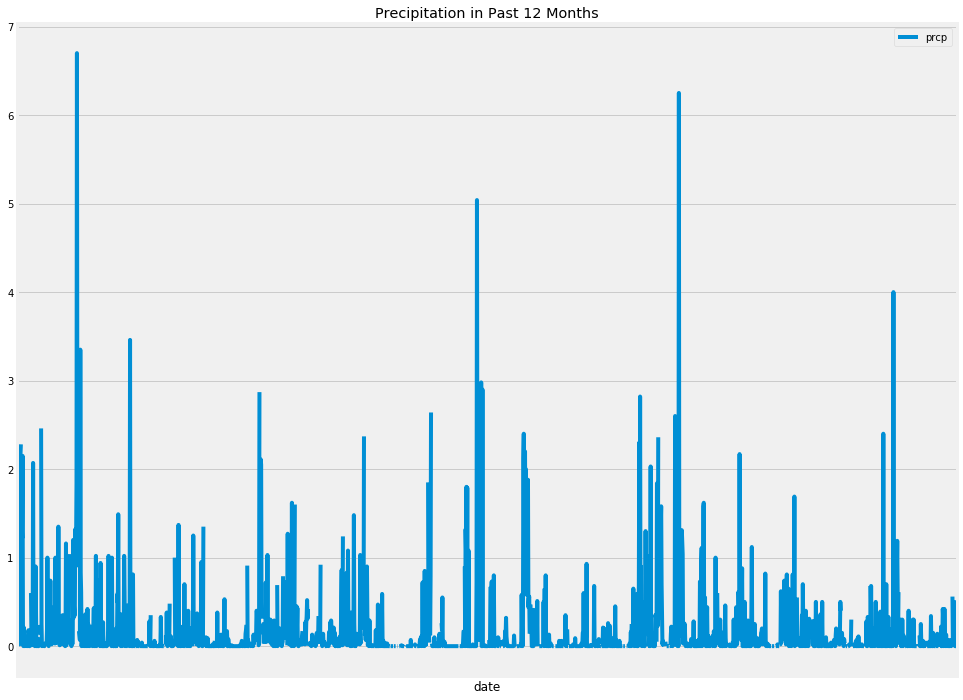

In [204]:
prec_p12m_df.plot(title='Precipitation in Past 12 Months',figsize=[15,12],legend=True,xticks=[])

In [205]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prec_p12m_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [206]:
# Design a query to show how many stations are available in this dataset?
measurement_df=pd.DataFrame(session.query(Measurement.id, Measurement.station, Measurement.date, Measurement.prcp,Measurement.tobs))
measurement_df
station_number = measurement_df.station.nunique()
print(f"There are {station_number} stations available in the dataset.")

There are 9 stations available in the dataset.


In [207]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
measurement_df.station.value_counts().sort_values(ascending=False)

USC00519281    2772
USC00519397    2724
USC00513117    2709
USC00519523    2669
USC00516128    2612
USC00514830    2202
USC00511918    1979
USC00517948    1372
USC00518838     511
Name: station, dtype: int64

In [198]:
# Using the station id from the previous query, calculate the lowest temperature recorded, highest temperature recorded, and average temperature of the most active station?
lowest_temp=session.query(func.min(Measurement.tobs)).filter(Measurement.station=='USC00519281').all()
highest_temp=session.query(func.max(Measurement.tobs)).filter(Measurement.station=='USC00519281').all()
avg_temp=session.query(func.avg(Measurement.tobs)).filter(Measurement.station=='USC00519281').all()
print(f"The most active station is USC00519281.")
print(f"The lowest temperaturer recorded is {lowest_temp[0][0]}.")
print(f"The highest temperature recorded is {highest_temp[0][0]}.")
print(f"The average temperature recorded is {avg_temp[0][0]}.")


The most active station is USC00519281.
The lowest temperaturer recorded is 54.0.
The highest temperature recorded is 85.0.
The average temperature recorded is 71.66378066378067.


In [224]:
# Alternatively:
# print(session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).all())

[(53.0, 87.0, 73.09795396419437)]


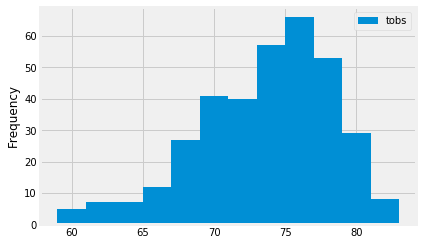

In [208]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
most_active_stn_df=pd.DataFrame(session.query(Measurement.station, Measurement.tobs).filter(Measurement.station=='USC00519281').filter(Measurement.date >= past_date_12mths).all())
most_active_stn_df.plot(kind='hist',bins=12)

In [209]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [210]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax for your trip using the previous year's data for those same dates.
print(calc_temps(past_date_12mths,ini_date_time))

[(58.0, 74.59058295964125, 87.0)]


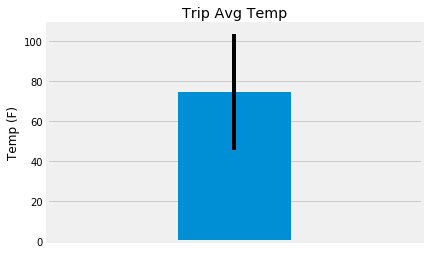

In [211]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
trip_data = pd.DataFrame(calc_temps(past_date_12mths,ini_date_time)[0],columns=['Temperature'])
yerror=trip_data_1.Temperature[2]-trip_data_1.Temperature[0]
plt.bar(x=0.5,height=trip_data_1.Temperature.Avg,yerr=yerror,width=0.3)
plt.title("Trip Avg Temp")
plt.xlim(0,1)
plt.xticks([])
plt.ylabel("Temp (F)")
plt.show()

In [315]:
station_df=pd.DataFrame(session.query(Station.id,Station.station,Station.name,Station.latitude,Station.longitude,Station.elevation).all())
station_df

,id,station,name,latitude,longitude,elevation
0,1,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0
1,2,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6
2,3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0
3,4,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9
4,5,USC00518838,"UPPER WAHIAWA 874.3, HI US",21.49920,-158.01110,306.6
5,6,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5
6,7,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
7,8,USC00511918,"HONOLULU OBSERVATORY 702.2, HI US",21.31520,-157.99920,0.9
8,9,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4


In [336]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

sel=[Measurement.station,func.sum(Measurement.prcp),Station.name,Station.latitude,Station.longitude,Station.elevation]
prep_stn_join=session.query(*sel).\
                filter(Measurement.station==Station.station).\
                filter(Measurement.date >= past_date_12mths).\
                group_by(Measurement.station).\
                order_by(func.sum(Measurement.prcp).desc()).all()

for record in prep_stn_join:
    (Measurement_station, Measurement.prcp,Station_name,Station_latitude,Station_longitude,Station_elevation)=record
    print(record)

('USC00519397', 55490938.10999987, 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0)
('USC00519281', 54107507.51999989, 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9)
('USC00516128', 53646363.9899999, 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4)
('USC00513117', 52724076.92999991, 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6)
('USC00519523', 51801789.86999992, 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5)
('USC00514830', 46882925.54999999, 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0)
('USC00517948', 28129755.33000011, 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9)


## Optional Challenge Assignment

In [26]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [27]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [28]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [29]:
# Plot the daily normals as an area plot with `stacked=False`
